In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf


2023-06-29 16:53:29.534203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 16:53:29.648340: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ttest_rel, ttest_ind
from scipy import stats
from keras.layers import Input, GRU, Conv1D, MaxPooling1D, AveragePooling1D, Lambda, concatenate, Dense, Dropout
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
import cms_preprocess

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf


In [4]:
# Split the data into train and test sets
x_train, x_val, y_train, y_val, dv_train, dv_val, test_input, test_dv, test_target = cms_preprocess.get_mhe(cms_preprocess.ben_path,
  cms_preprocess.ip_path, cms_preprocess.pde_path, cms_preprocess.dx_path, cms_preprocess.pcs_path, cms_preprocess.ben_cols,
  cms_preprocess.ip_cols, cms_preprocess.pde_cols, rows=60000, start_year=2008, end_year=2010, random_state = 42, col_num=6)

/local-scratch/localhome/rka73/local_rk_orx/cms_preprocess.py:45: DtypeWarning: Columns (1,3,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ben = pd.read_csv(ben_path, usecols=ben_cols)
/local-scratch/localhome/rka73/local_rk_orx/cms_preprocess.py:46: DtypeWarning: Columns (1,3,30) have mixed types. Specify dtype option on import or set low_memory=False.
  ip = pd.read_csv(ip_path, usecols=ip_cols)
/local-scratch/localhome/rka73/local_rk_orx/cms_preprocess.py:47: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pde = pd.read_csv(pde_path, usecols=pde_cols)


In [5]:
batch_size = 32
epochs=10

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the CNN model
    data_input = tf.keras.layers.Input(shape=(366, 516))  # input shape for non-demographic variables data
    dv_input = tf.keras.layers.Input(shape=(2,))  # input shape for demographic variables
    x = tf.keras.layers.Reshape((366, 516, 1))(data_input)  # reshape the input to a 4D tensor
    x = tf.keras.layers.Conv2D(100, (366, 516), activation='relu')(x)  # convolutional layer with 100 filters
    x = tf.keras.layers.MaxPooling2D((1, 1))(x)  # max pooling layer
    x = tf.keras.layers.Dropout(0.5)(x)  # dropout layer to prevent overfitting
    x = tf.keras.layers.Flatten()(x)  # flatten the output from the convolutional layer
    concatenated = tf.keras.layers.concatenate([x, dv_input])  # concatenate the demographic variables with the flattened output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)  # dense, fully connected layer with a sigmoid activation
    model = tf.keras.Model(inputs=[data_input, dv_input], outputs=output)  # define the model with inputs and outputs

    # Compile the model with both the loss and accuracy metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit((x_train, dv_train), y_train, epochs=epochs, batch_size=batch_size, validation_data=((x_val, dv_val), y_val))
    
    # Plot the loss and accuracy
    # fig, ax = plt.subplots(figsize=(8, 6))
    # ax.plot(history.history['loss'], label='Training Loss')
    # ax.plot(history.history['accuracy'], label='Training Accuracy')
    # ax.plot(history.history['val_loss'], label='Validation Loss')
    # ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    # ax.set_title('Model Loss and Accuracy', fontsize=16)
    # ax.set_xlabel('Epoch', fontsize=14)
    # ax.set_ylabel('Loss / Accuracy', fontsize=14)
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.legend(fontsize=12)
    # plt.show()


2023-06-29 17:03:24.193637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-29 17:03:24.194224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: bdhub-its54313
2023-06-29 17:03:24.194424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: bdhub-its54313
2023-06-29 17:03:24.195334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.30.2
2023-06-29 17:03:24.196036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.30.2
2023-06-29 17:03:24.196040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.30.2
2023-06-29 17:03:24.204921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10


2023-06-29 17:04:16.563494: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - ETA: 0s - loss: 1.1009 - accuracy: 0.8734

2023-06-29 17:07:16.242078: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 182s 149ms/step - loss: 1.1009 - accuracy: 0.8734 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 2/10
1200/1200 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9990

2023-06-29 17:08:50.765804: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 94s 79ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0085 - val_accuracy: 0.9990
Epoch 3/10
1200/1200 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993

2023-06-29 17:10:25.423775: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0086 - val_accuracy: 0.9990
Epoch 4/10
1200/1200 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996

2023-06-29 17:12:00.134878: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0091 - val_accuracy: 0.9990
Epoch 5/10
1200/1200 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996

2023-06-29 17:13:34.904050: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0094 - val_accuracy: 0.9991
Epoch 6/10
1200/1200 [==============================] - ETA: 0s - loss: 7.5712e-04 - accuracy: 0.9997

2023-06-29 17:15:09.659631: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 7.5712e-04 - accuracy: 0.9997 - val_loss: 0.0096 - val_accuracy: 0.9991
Epoch 7/10
1200/1200 [==============================] - ETA: 0s - loss: 5.0451e-04 - accuracy: 0.9999

2023-06-29 17:16:44.353549: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 5.0451e-04 - accuracy: 0.9999 - val_loss: 0.0106 - val_accuracy: 0.9992
Epoch 8/10
1200/1200 [==============================] - ETA: 0s - loss: 3.0325e-04 - accuracy: 0.9999

2023-06-29 17:18:19.067713: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 3.0325e-04 - accuracy: 0.9999 - val_loss: 0.0118 - val_accuracy: 0.9992
Epoch 9/10
1200/1200 [==============================] - ETA: 0s - loss: 1.4577e-04 - accuracy: 1.0000

2023-06-29 17:19:53.841188: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 1.4577e-04 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9992
Epoch 10/10
1200/1200 [==============================] - ETA: 0s - loss: 7.5970e-05 - accuracy: 1.0000

2023-06-29 17:21:28.610585: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1200/1200 [==============================] - 95s 79ms/step - loss: 7.5970e-05 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9992


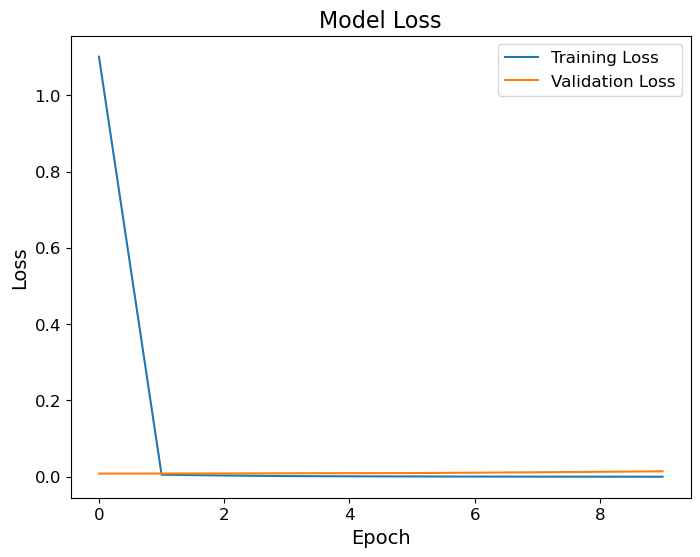

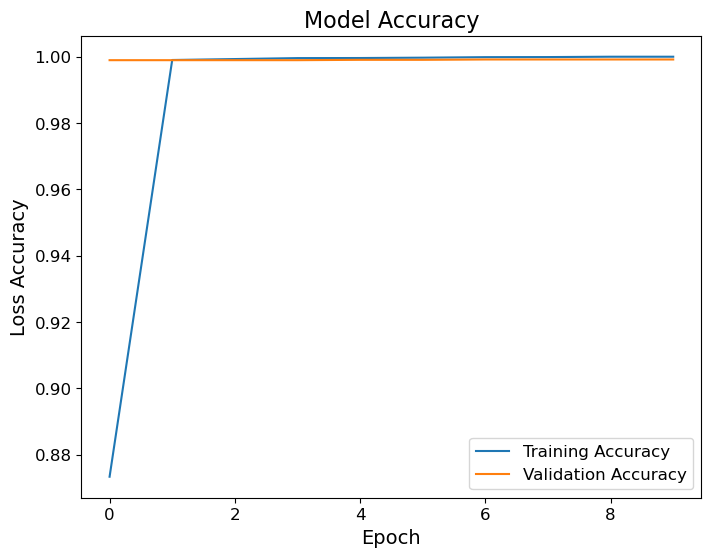

In [6]:
# Plot the loss and accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Model Loss', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

# Plot the loss and accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('Model Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss Accuracy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [7]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split train data and demographic variables into chunks
chunk_size = len(x_train) // num_chunks
train_chunks = [x_train[i:i+chunk_size] for i in range(0, len(x_train), chunk_size)]
dv_chunks = [dv_train[i:i+chunk_size] for i in range(0, len(dv_train), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(train_chunks):
    dv_chunk = dv_chunks[i]
    chunk_predictions = model.predict([chunk, dv_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)

preds = np.copy(predictions)
preds = np.squeeze(preds)

# Find the F1 score for different threshold values
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_train, (preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:" ,best_threshold)

 23/160 [===>..........................] - ETA: 0s

2023-06-29 17:22:00.832101: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 31/160 [====>.........................] - ETA: 0s

2023-06-29 17:22:34.077480: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 34/160 [=====>........................] - ETA: 0s

2023-06-29 17:23:10.415861: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 30/160 [====>.........................] - ETA: 0s

2023-06-29 17:23:40.995052: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


160/160 [==============================] - 1s 5ms/step
Best threshold: 0.03


In [8]:
# Get the prediction for some samples in the test set
sample = test_input[np.where(test_target==1)[0]]
dv_sample = test_dv[np.where(test_target==1)[0]]

prediction = model.predict([np.array(sample), dv_sample])

# Print the prediction
print('Prediction:', prediction)

1/1 [==============================] - 1s 1s/step
Prediction: [[6.1659310e-05]
 [5.1290810e-10]
 [9.5801420e-09]
 [9.9338621e-01]
 [1.9099870e-08]
 [7.7228498e-01]
 [9.8229688e-01]
 [1.8641487e-05]
 [7.7228498e-01]
 [3.7071710e-10]
 [9.6425939e-01]
 [4.9651401e-08]
 [9.9115515e-01]]


32/50 [==================>...........] - ETA: 0s

2023-06-29 17:24:11.791443: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


50/50 [==============================] - 0s 5ms/step


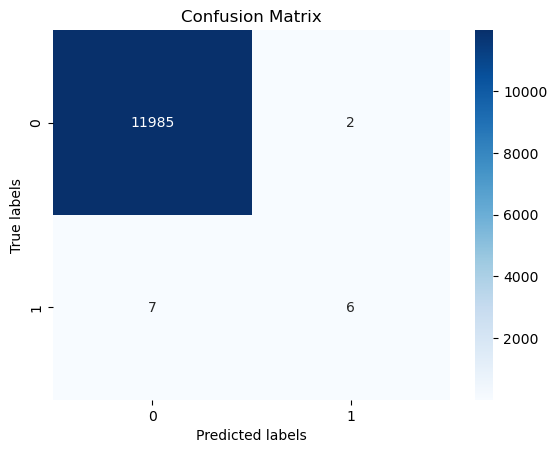

AUC: 0.7307
Precision with recall set to 0.9: 0.1402


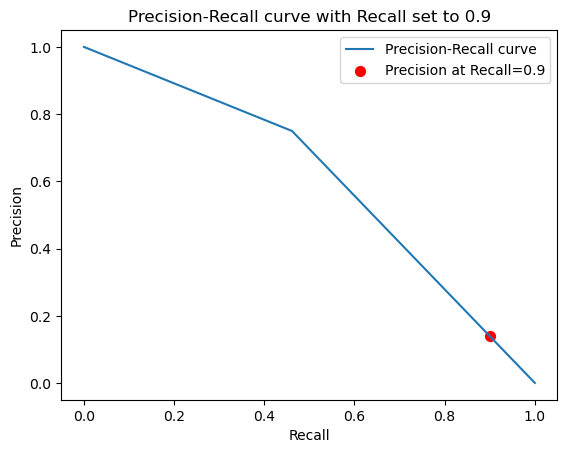

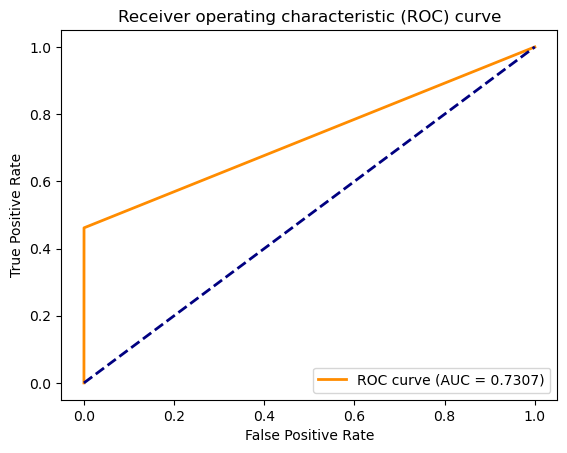

In [9]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split test data and demographic variables into chunks
chunk_size = len(test_input) // num_chunks
test_chunks = [test_input[i:i+chunk_size] for i in range(0, len(test_input), chunk_size)]
dv_chunks = [test_dv[i:i+chunk_size] for i in range(0, len(test_dv), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(test_chunks):
    dv_chunk = dv_chunks[i]
    chunk_predictions = model.predict([chunk, dv_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)

# Convert the continuous predictions to binary classes
preds = np.copy(predictions)
preds = [1 if y > best_threshold else 0 for y in preds]

# Compute the confusion matrix
cm = confusion_matrix(test_target, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# Compute the AUC
auc_score = roc_auc_score(test_target, preds)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(test_target, preds)
precision_at_recall_09 = np.interp(0.9, recall[::-1], precision[::-1])
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Plot the precision-recall curve with recall set to 0.9
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(0.9, precision_at_recall_09, s=50, color='red', label='Precision at Recall=0.9')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve with Recall set to 0.9')
plt.legend()
plt.show()

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(test_target, preds)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()
